In [76]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

tf.config.threading.set_intra_op_parallelism_threads(4)
# model architecture
class RankNet(Model):
    def __init__(self):
        super(RankNet, self).__init__()
        self.dense1 = layers.Dense(16, activation=leaky_relu)
        self.dense2 = layers.Dense(8, activation=leaky_relu)
        self.o = layers.Dense(1)
        self.subtract = layers.Subtract()
        self.activation = layers.Activation('sigmoid')

    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense1(xi)
        densej = self.dense1(xj)
        densei = self.dense2(densei)
        densej = self.dense2(densej)
        oi = self.o(densei)
        oj = self.o(densej)
        oij = self.subtract([oi, oj])
        output = self.activation(oij)
        return output

    def build_graph(self):
        x = [Input(shape=(169)), Input(shape=(169))]
        return Model(inputs=x, outputs=self.call(x))
    

In [78]:
import pandas as pd
model_df = pd.read_excel("model_df.xlsx", index_col = 0)

In [79]:
model_df["raceId"].unique()

array([ 900,  901,  902,  903,  904,  905,  906,  907,  908,  909,  910,
        911,  912,  913,  914,  915,  916,  917,  918,  926,  927,  928,
        929,  930,  931,  932,  933,  934,  936,  937,  938,  939,  940,
        941,  942,  943,  944,  945,  948,  949,  950,  951,  952,  953,
        954,  955,  956,  957,  958,  959,  960,  961,  962,  963,  964,
        965,  966,  967,  968,  969,  970,  971,  972,  973,  974,  975,
        976,  977,  978,  979,  980,  981,  982,  983,  984,  985,  986,
        987,  988,  989,  990,  991,  992,  993,  994,  995,  996,  997,
        998,  999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008,
       1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019,
       1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1031, 1028, 1029,
       1030, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041,
       1042, 1043, 1044, 1045, 1046, 1047, 1052, 1053, 1054, 1055, 1056,
       1057, 1059, 1058, 1060, 1061, 1062, 1063, 10

In [80]:
# generate data
nb_query = len(model_df["raceId"].unique())
### in each query number of docs can be diffrent
query = model_df["raceId"].to_numpy()
### for each doc we can take some random features
temp_data = model_df.drop(["time", "end_position", "raceId"], axis = 1)
# doc_scores = []
# for q in range(nb_query):
#     query_idx = np.where(query == q)[0]
#     temp = temp_data.iloc[query_idx,:].values.tolist()
#     doc_scores.append(temp)

doc_scores = model_df["end_position"].values
doc_features = temp_data.values

doc_features.shape


(2157, 169)

In [81]:

# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
### for each query we must create all pairs
for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    # print(query_idx)
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)
        
        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(doc_features[i]) # features of first doc in pair
        xj.append(doc_features[j]) # features of second doc in pair
        
        
        if doc_scores[i] == doc_scores[j]:
            _pij = 0.5
        elif doc_scores[i] > doc_scores[j]:
            _pij = 1
        else: 
            _pij = 0
        pij.append(_pij)
        
xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)

xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)


In [82]:
xi

array([[ 2.01400000e+03, -2.67355573e-01,  1.38843029e+00, ...,
         0.00000000e+00,  0.00000000e+00,  7.50000000e+01],
       [ 2.01400000e+03, -2.67355573e-01,  1.38843029e+00, ...,
         0.00000000e+00,  0.00000000e+00,  7.50000000e+01],
       [ 2.01400000e+03, -2.67355573e-01,  1.38843029e+00, ...,
         0.00000000e+00,  0.00000000e+00,  7.50000000e+01],
       ...,
       [ 2.02400000e+03, -1.98885409e+00, -1.29564712e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.26000000e+02],
       [ 2.02400000e+03, -1.98885409e+00, -1.29564712e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.26000000e+02],
       [ 2.02400000e+03, -1.02446767e+00, -4.26158632e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.26000000e+02]])

In [83]:
# train model using compile and fit

ranknet_model = RankNet()
ranknet_model.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet_model.fit([xi_train, xj_train], pij_train, epochs=20, batch_size=4, validation_data=([xi_test, xj_test], pij_test))

Epoch 1/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4452 - val_loss: 0.3752
Epoch 2/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3898 - val_loss: 0.3740
Epoch 3/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3888 - val_loss: 0.3730
Epoch 4/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3732 - val_loss: 0.3729
Epoch 5/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3917 - val_loss: 0.3718
Epoch 6/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3863 - val_loss: 0.3724
Epoch 7/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3947 - val_loss: 0.3759
Epoch 8/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3717 - val_loss: 0.3735
Epoch 9/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3791 - val_loss: 0.3720
Epoch 10/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3943 - val_loss: 0.3730
Epoch 11/20
2312/2312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3865 - val_loss: 0.3718
Epoch 12/20
2312/2312 ━━━━━━━━

In [84]:
# train model using compile and fit

ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=500, batch_size=2, validation_data=([xi_test, xj_test], pij_test))

Epoch 1/500
4623/4623 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.4625 - val_loss: 0.3827
Epoch 2/500
3671/4623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4003

KeyboardInterrupt: 

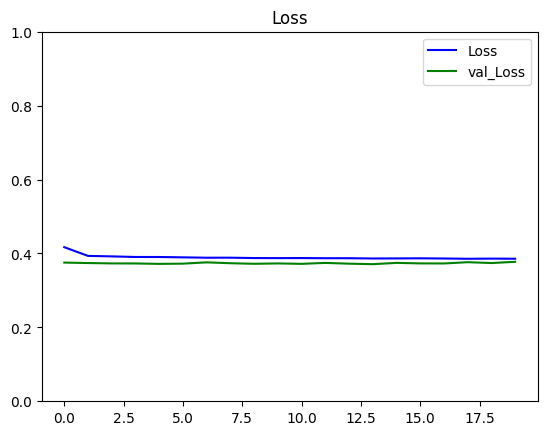

In [85]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [ ]:
def predict_ranking(model, docks):
    """
    Predict the ranking of docks using a trained RankNet model.
    
    Args:
        model (RankNet): A trained RankNet model.
        docks (np.array): A 2D numpy array where each row represents a dock's features.
    
    Returns:
        np.array: A NumPy array representing the predicted ranking of docks.
    """
    # Number of docks
    n_docks = docks.shape[0]
    
    # Generate all pairs of docks
    dock_indices = np.arange(n_docks)
    dock_pairs = np.array(list(combinations(dock_indices, 2)))
    
    # Prepare input arrays for model prediction
    xi = docks[dock_pairs[:, 0]]
    xj = docks[dock_pairs[:, 1]]
    
    # Predict pairwise preferences
    pairwise_preds = model.predict([xi, xj])
    
    # Initialize score array
    scores = np.zeros(n_docks)
    
    # Aggregate pairwise predictions into scores
    for (i, j), pred in zip(dock_pairs, pairwise_preds):
        if pred > 0.5:  # i is preferred over j
            scores[i] += 1
        else:           # j is preferred over i
            scores[j] += 1
    
    # Sort docks by their scores in descending order
    ranked_indices = np.argsort(-scores)  # Descending order
    
    return ranked_indices

In [ ]:

df_results = pd.DataFrame(columns = ["data", "pred"])

for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    ranking = predict_ranking(ranknet, doc_features[query_idx])
    comparison = np.stack((ranking, doc_scores[query_idx]), axis = 1)
    temp = pd.DataFrame(comparison, columns = ["data", "pred"])
    df_results = pd.concat((df_results, temp))

        


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━

In [ ]:
# df_results.to_excel("results.xlsx")
dock_indices = np.arange(10)
dock_pairs = np.array(list(combinations(dock_indices, 2)))
temp = xi[dock_pairs[:, 0]]
temp

array([[ 2.01400000e+03, -2.67355573e-01,  1.38843029e+00, ...,
         0.00000000e+00,  0.00000000e+00,  7.50000000e+01],
       [ 2.01400000e+03, -2.67355573e-01,  1.38843029e+00, ...,
         0.00000000e+00,  0.00000000e+00,  7.50000000e+01],
       [ 2.01400000e+03, -2.67355573e-01,  1.38843029e+00, ...,
         0.00000000e+00,  0.00000000e+00,  7.50000000e+01],
       ...,
       [ 2.01400000e+03, -6.98767652e-02, -3.76303535e-01, ...,
         0.00000000e+00,  1.00000000e+00,  7.50000000e+01],
       [ 2.01400000e+03, -6.98767652e-02, -3.76303535e-01, ...,
         0.00000000e+00,  1.00000000e+00,  7.50000000e+01],
       [ 2.01400000e+03, -6.98767652e-02, -3.76303535e-01, ...,
         0.00000000e+00,  1.00000000e+00,  7.50000000e+01]])

In [ ]:
pairwise_preds = ranknet_model.predict([xi[0:9,:], xj[0:9,:]])
pairwise_preds

# [i.shape for i in [xi[0:1,:], xj[0:1,:]]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


array([[0.10324178],
       [0.47266066],
       [0.03913599],
       [0.09474443],
       [0.24619338],
       [0.06296633],
       [0.05359108],
       [0.8861744 ],
       [0.26132208]], dtype=float32)